

**Vector Arithmetic in Latent Space**
The generator model in the GAN architecture takes a point from the latent space as input and generates a new image.


A series of points can be created on a linear path between two points in the latent space, such as two generated images. These points can be used to generate a series of images that show an interpolation between the two generated images, one cn also operate arithmetic operations on these points, (Alec Radford, et al.  “Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks” 2015).

In the paper, the authors ilustrated the vector arithmetic with faces. For example, a face of a smiling woman minus the face of a neutral woman plus the face of a neutral man resulted in the face of a smiling man.

Specifically, the arithmetic was performed on the points in the latent space for the resulting faces. Actually on the average of multiple faces with a given characteristic, to provide a more robust result.

![Example of Vector Arithmetic on Points in the Latent Space for Generating Faces With a GAN.](https://machinelearningmastery.com/wp-content/uploads/2019/05/Example-of-Vector-Arithmetic-on-Points-in-the-Latent-Space-for-Generating-Faces-with-a-GAN-1024x531.png)

The second demonstration was the transition between two generated faces, specifically by creating a linear path through the latent dimension between the points that generated two faces and then generating all of the faces for the points along the path.

![Example of Faces on a Path Between Two GAN Generated Faces.](https://machinelearningmastery.com/wp-content/uploads/2019/05/Example-of-Faces-on-a-Path-Between-Two-GAN-Generated-Faces-1024x606.png)

Exploring the structure of the latent space for a GAN model is both interesting for the problem domain and helps to develop an intuition for what has been learned by the generator model.


## Large-Scale CelebFaces Dataset (CelebA)
The first step is to select a dataset of faces.

We will use the Large-scale CelebFaces Attributes Dataset, referred to as CelebA. This dataset was developed and published by Ziwei Liu, et al. for their 2015 paper titled “[From Facial Parts Responses to Face Detection: A Deep Learning Approach](https://arxiv.org/abs/1509.06451)”.

The dataset provides about 200,000 photographs of celebrity faces along with annotations for what appears in given photos, such as glasses, face shape, hats, hair type, etc. As part of the dataset, the authors provide a version of each photo centered on the face and cropped to the portrait with varying sizes around 150 pixels wide and 200 pixels tall. We will use this as the basis for developing our GAN model.

The prepared dataset can be downloaded from this link: https://partage.imt.fr/index.php/s/37GzrLdZkAyctnE

Load the data and show the i th face using matplotlib library

In [1]:
!wget 'https://nextcloud.univ-lille.fr/index.php/s/fJCDx8XCRdzDg3y/download/img_align_celeba.npz'

--2022-03-04 10:01:39--  https://nextcloud.univ-lille.fr/index.php/s/fJCDx8XCRdzDg3y/download/img_align_celeba.npz
Resolving nextcloud.univ-lille.fr (nextcloud.univ-lille.fr)... 194.254.129.23, 194.254.129.22
Connecting to nextcloud.univ-lille.fr (nextcloud.univ-lille.fr)|194.254.129.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 888614524 (847M) [application/octet-stream]
Saving to: ‘img_align_celeba.npz’

img_align_celeba.np 100%[===================>] 847.45M  31.1MB/s    in 29s     

2022-03-04 10:02:09 (29.5 MB/s) - ‘img_align_celeba.npz’ saved [888614524/888614524]



In [2]:
from numpy import load
images = load('img_align_celeba.npz')
import matplotlib.pyplot as plt
image = images['arr_0']

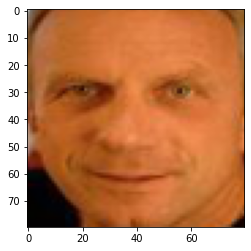

In [3]:
i = 1
plt.imshow(image[i,:,:])

Review the generated plots and select a model based on the best quality images.

The model should begin to generate faces after about 30 training epochs.

The faces are not completely clear, but it is obvious that they are faces, with all the right things (hair, eyes, nose, mouth) in roughly the right places.

The generator model (.h5) can be downloaded as follows via this link: https://partage.imt.fr/index.php/s/aZPpzwQfJHjXFxe

### How to Load Model and Generate Faces
The first step is to load the saved model and confirm that it can generate plausible faces.

The model can be loaded using the load_model() function in the Keras API. We can then generate a number of random points in the latent space and use them as input to the loaded model to generate new faces. The faces can then be plotted.


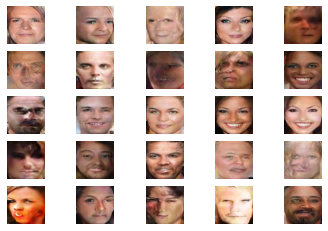

In [5]:
# load model
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# create a plot of generated images
def plot_generated(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()
model = load_model('generator_model_030.h5')

latent_points = generate_latent_points(100, 25)
# generate images
X  = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
plot_generated(X, 5)



### How to Interpolate Between Generated Faces
Next, we can create an interpolation path between two points in the latent space and generate faces along this path.

The simplest interpolation we can use is a linear or uniform interpolation between two points in the latent space. We can achieve this using the linspace() NumPy function to calculate ratios of the contribution from two points, then enumerate these ratios and construct a vector for each ratio.

The interpolate_points() function below implements this and returns a series of linearly interpolated vectors between two points in latent space, including the first and last point.

In [6]:
#def interpolate_points(p1, p2, n_steps=10):
# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):


	"""Uniform interpolation between two points in latent space

	Args:
		p1 (numpy.ndarray): a first point in the latent space
		p2 (numpy.ndarray): a second point in the latent space
		n_steps (int): number of interpolated points in latent space

	Returns:
		a numpy.ndarray containing the series of linearly interpolated vectors between p1 and p2 in latent space
	"""
	ratios = linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return asarray(vectors)

Run the interpolation path between two points in latent space, generate images for each, and plot the result.

You should see the clear linear progression in ten steps from the first face on the left to the final face on the right.

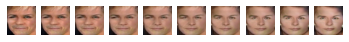

In [7]:
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from numpy import linspace
from keras.models import load_model
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input
 
# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
	# interpolate ratios between the points
	ratios = linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return asarray(vectors)
 
# create a plot of generated images
def plot_generated(examples, n):
	# plot images
	for i in range(n):
		# define subplot
		pyplot.subplot(1, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()
 
# load model
model = load_model('generator_model_030.h5')
# generate points in latent space
pts = generate_latent_points(100, 2)
# interpolate points in latent space
interpolated = interpolate_points(pts[0], pts[1])
# generate images
X = model.predict(interpolated)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
plot_generated(X, len(interpolated))

Update the example to repeat this process multiple times so you can see the transition between multiple generated faces on a single plot.

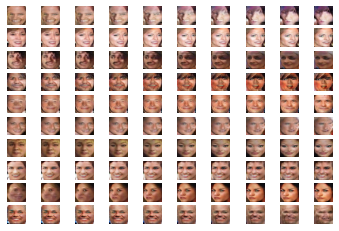

In [8]:
from numpy import asarray
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from numpy import arccos
from numpy import clip
from numpy import dot
from numpy import sin
from numpy import linspace
from numpy.linalg import norm
from keras.models import load_model
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input
 
# spherical linear interpolation (slerp)
def slerp(val, low, high):
	omega = arccos(clip(dot(low/norm(low), high/norm(high)), -1, 1))
	so = sin(omega)
	if so == 0:
		# L'Hopital's rule/LERP
		return (1.0-val) * low + val * high
	return sin((1.0-val)*omega) / so * low + sin(val*omega) / so * high
 
# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
	# interpolate ratios between the points
	ratios = linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = slerp(ratio, p1, p2)
		vectors.append(v)
	return asarray(vectors)
 
# create a plot of generated images
def plot_generated(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()
 
# load model
model = load_model('generator_model_030.h5')
# generate points in latent space
n = 20
pts = generate_latent_points(100, n)
# interpolate pairs
results = None
for i in range(0, n, 2):
	# interpolate points in latent space
	interpolated = interpolate_points(pts[i], pts[i+1])
	# generate images
	X = model.predict(interpolated)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	if results is None:
		results = X
	else:
		results = vstack((results, X))
# plot the result
plot_generated(results, 10)

In these cases, we have performed a linear interpolation which assumes that the latent space is uniformly distributed hypercube. Technically, our chosen latent space is a 100-dimension hypersphere or multimodal Gaussian distribution.

There is a mathematical function called the spherical linear interpolation function, or 'Slerp' that should be used when interpolating this space to ensure the curving of the space is taken into account. For more details, I recommend reading the [Issue on Linear Interpolation in Soumith Chintala’s dcgan.torch project](https://github.com/soumith/dcgan.torch/issues/14). In that project, an implementation of the Slerp function for Python is provided that we can use as the basis for our own Slerp function, provided below:

In [9]:
from numpy import arccos
from numpy import clip
from numpy import dot
from numpy import sin
from numpy.linalg import norm

# spherical linear interpolation (slerp)
def slerp(val, low, high):
	omega = arccos(clip(dot(low/norm(low), high/norm(high)), -1, 1))
	so = sin(omega)
	if so == 0:
		# L'Hopital's rule/LERP
		return (1.0-val) * low + val * high
	return sin((1.0-val)*omega) / so * low + sin(val*omega) / so * high

This function can be called from our interpolate_points() function instead of performing the manual linear interpolation.

Update the interpolate_points() function with the slerp function, and plot the results.

The difference is subtle but somehow visually more correct.

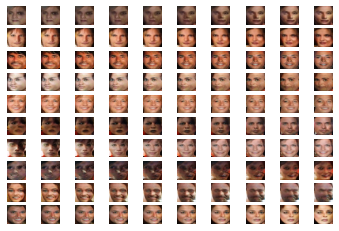

In [10]:

# example of interpolating between generated faces
from numpy import asarray
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from numpy import arccos
from numpy import clip
from numpy import dot
from numpy import sin
from numpy import linspace
from numpy.linalg import norm
from keras.models import load_model
from matplotlib import pyplot
 
 
# spherical linear interpolation (slerp)
def slerp(val, low, high):
	omega = arccos(clip(dot(low/norm(low), high/norm(high)), -1, 1))
	so = sin(omega)
	if so == 0:
		# L'Hopital's rule/LERP
		return (1.0-val) * low + val * high
	return sin((1.0-val)*omega) / so * low + sin(val*omega) / so * high
 
# load model
model = load_model('generator_model_030.h5')
# generate points in latent space
n = 20
pts = generate_latent_points(100, n)
# interpolate pairs
results = None
for i in range(0, n, 2):
	# interpolate points in latent space
	interpolated = interpolate_points(pts[i], pts[i+1])
	# generate images
	X = model.predict(interpolated)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	if results is None:
		results = X
	else:
		results = vstack((results, X))
# plot the result
plot_generated(results, 10)


### How to Perform Vector Arithmetic With Faces
Finally, we can explore the latent space by performing vector arithmetic with the generated faces.

First, we must generate a large number of faces and save both the faces and their corresponding latent vectors. We can then review the plot of generated faces and select faces with features we’re interested in, note their index (number), and retrieve their latent space vectors for manipulation.

(1) Load the GAN model, (2) generate 100 latent vectors and save them with the filename ‘latent_points.npz‘, (3) generate 100 faces and plot them in a 10×10 grid and save it in a file named ‘generated_faces.png‘.

In [11]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
from numpy import savez_compressed
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input
 
# create a plot of generated images
def plot_generated(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.savefig('generated_faces.png')
	pyplot.close()
 
# load model
model = load_model('generator_model_030.h5')
# generate points in latent space
latent_points = generate_latent_points(100, 100)
# save points
savez_compressed('latent_points.npz', latent_points)
# generate images
X  = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# save plot
plot_generated(X, 10)

In this case, we have a good collection of faces to work with. Each face has an index that we can use to retrieve the latent vector. For example, the first face is 1, which corresponds to the first vector in the saved array (index 0).

We will perform the operation:

smiling woman - neutral woman + neutral man = smiling man

Therefore, we need three faces for each of smiling woman, neutral woman, and neutral man.

In this case, we will use the following indexes in the image:

- Smiling Woman: 5, 6, 98
- Neutral Woman: 33, 53, 62
- Neutral Man: 92, 98, 99


Now that we have latent vectors to work with and a target arithmetic, we can get started.

First, we can specify our preferred images and load the saved NumPy array of latent points.

In [82]:
from numpy import load

# load the saved latent points
data = load('latent_points.npz')
points = data['arr_0']
# retrieve specific points
# smiling_woman_ix = [5, 6, 98]
# neutral_woman_ix = [33, 53, 62]
# neutral_man_ix = [92, 98, 99]

smiling_woman_ix = [1, 15, 23]
neutral_woman_ix = [75, 55, 25]
neutral_man_ix = [44, 24, 39]

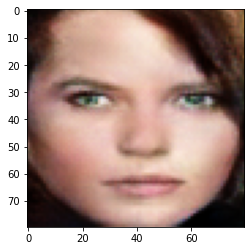

In [83]:
plt.imshow(X[55, :, :])

Next, we can retrieve each vector and calculate the average for each vector type (e.g. smiling woman). We could perform vector arithmetic with single images directly, but we will get a more robust result if we work with an average of a few faces with the desired property.

Implement the average_points() function that takes the loaded array of latent space points, retrieves each, and calculates the average.

In [84]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
from numpy import load
from numpy import mean
from numpy import vstack
from numpy import expand_dims

def average_points(points, ix):
	"""Average list of latent space vectors

	Args:
		points (numpy.ndarray): an array of shape (n_points, latent_dim) containing several points in latent space
		ix (list): a list of integers to retrieve required points

	Returns:
		the average point
	"""
	# convert to zero offset points
	# zero_ix = [i-1 for i in ix]
	# retrieve required points
	vectors = points[ix]
	# average the vectors
	avg_vector = mean(vectors, axis=0)
	# combine original and avg vectors
	all_vectors = vstack((vectors, avg_vector))
	return all_vectors


# create a plot of generated images
def plot_generated(examples, rows, cols):
	# plot images
	for i in range(rows * cols):
		# define subplot
		pyplot.subplot(rows, cols, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

We can now use this function to retrieve all of the required points in latent space and generate images.

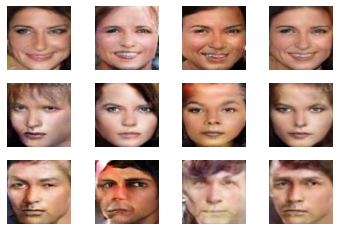

In [85]:
smiling_woman = average_points(points, smiling_woman_ix)
neutral_woman = average_points(points, neutral_woman_ix)
neutral_man = average_points(points, neutral_man_ix)
# combine all vectors
all_vectors = vstack((smiling_woman, neutral_woman, neutral_man))
# generate images
images = model.predict(all_vectors)
# scale pixel values
images = (images + 1) / 2.0
plot_generated(images, 3, 4)

Perform vector arithmetic in latent space and plot the result.

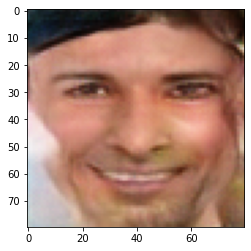

In [86]:
# smiling woman - neutral woman + neutral man = smiling man
result_vector = smiling_woman[-1] - neutral_woman[-1] + neutral_man[-1]
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()

Running the example first loads the points in latent space for our specific images, calculates the average of the points, and generates the faces for the points.

We can see that, indeed, our selected faces were retrieved correctly and that the average of the points in the vector space captures the salient feature we are going for on each line (e.g. smiling woman, neutral woman, etc.).

Next, vector arithmetic is performed and the result is a smiling man, as we would expect.

## Acknowledgment
This lab is inspired by J. B (Machine Learning with Python)